# 221 Assignment

### Tobias Reaper

Lambda School Data Science

Unit 2: Predictive Modeling

---
---

# Kaggle Challenge, Module 1

## Assignment
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.

---

## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.

#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```

---
---

## Assignment

---

#### Imports and Config

In [7]:
# The classix
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Testing out pyjanitor for data wrangling
import janitor

In [4]:
# Plotly imports
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

# Plotly config
# Set plotly to notebook mode / work offline
pyo.init_notebook_mode()

In [5]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [6]:
# Set pandas display options to allow for more columns and rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)

In [9]:
# The skool kids
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

---

#### Do train/validate/test split with the Tanzania Waterpumps data.

In [91]:
DATA_PATH = '../data/'

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [92]:
# Split up train into train and validation
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=92)

---

#### Define a function to wrangle train, validate, and test sets in the same way. 

Clean outliers and engineer features. 

> [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) 

- What other columns are duplicates, or nearly duplicates?
- Can you extract the year from date_recorded?
- Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?

In [73]:
# First, I need a lay o' the data
# train.profile_report(style={"full_width": True})  # Takes a long time with the amount of data / features
train.head(16)

id  amount_tsh date_recorded  gps_height  longitude   latitude  \
22586  11611         NaN    2011-07-12         NaN  30.942205  -1.029911   
47046  10605         NaN    2011-07-13         NaN  31.479394  -1.375950   
2808   64307       500.0    2011-10-04      1506.0  34.648047  -8.972701   
3758   64534         NaN    2012-10-22      1375.0  34.264181  -2.939733   
57984   1888         NaN    2013-03-16      1987.0  36.210766  -2.935612   
10084  11967         NaN    2013-01-17       -12.0  39.411485  -8.756638   
3423   33218         NaN    2013-01-29       322.0  38.997835 -10.329447   
47432  38150         7.0    2013-11-03      1296.0  37.223607  -3.227003   
57486  70643         NaN    2011-07-09         NaN  30.629430  -2.743024   
28547  18251         NaN    2011-02-20      1395.0  34.616574  -9.972098   
16399  42607         NaN    2011-07-13         NaN  31.211358  -3.037457   
37629  68271         NaN    2013-03-13      1331.0  36.781841  -3.363420   
57204  50689         NaN    2011-03-17         NaN  35.451158  -5.836435   
33386  20324         NaN    2013-01-29      1870.0  31.667245  -8.070872   
25833   2732       200.0    2011-04-20       426.0  37.145388  -6.689239   
5091   47529         NaN    2013-01-21         NaN        NaN        NaN   

                         basin       region  district_code  population  \
22586            Lake Victoria       Kagera            7.0         NaN   
47046            Lake Victoria       Kagera            2.0         NaN   
2808                    Rufiji       Iringa            4.0       150.0   
3758             Lake Victoria    Shinyanga            1.0       500.0   
57984                 Internal       Arusha            6.0       250.0   
10084  Ruvuma / Southern Coast        Lindi           13.0      1000.0   
3423   Ruvuma / Southern Coast        Lindi           53.0       160.0   
47432                  Pangani  Kilimanjaro            5.0       234.0   
57486            Lake Victoria       Kagera           30.0         NaN   
28547               Lake Nyasa       Iringa            5.0         1.0   
16399          Lake Tanganyika       Kagera            4.0         NaN   
37629                  Pangani       Arusha            7.0        49.0   
57204                 Internal       Dodoma            6.0         NaN   
33386               Lake Rukwa        Rukwa            4.0      1850.0   
25833              Wami / Ruvu     Morogoro            1.0       250.0   
5091             Lake Victoria    Shinyanga            1.0         NaN   

      public_meeting permit  construction_year extraction_type   management  \
22586           True   True                NaN             ksb          vwc   
47046           True   True                NaN          swn 80          vwc   
2808            True   True             1984.0         gravity          wua   
3758            True  False             2007.0     nira/tanira          wug   
57984           True    NaN             2001.0         gravity          vwc   
10084           True   True             2000.0     submersible      unknown   
3423            True   True             1998.0     submersible          vwc   
47432           True   True             2008.0         gravity  water board   
57486           True  False                NaN           other          vwc   
28547          False  False             2008.0         gravity   parastatal   
16399           True   True                NaN         gravity          vwc   
37629           True   True             1985.0         gravity          vwc   
57204           True   True                NaN            mono          vwc   
33386           True   True             1986.0         gravity          vwc   
25833           True   True             1976.0          swn 80          vwc   
5091            True  False                NaN     nira/tanira          wug   

      management_group payment_type water_quality      quantity        source  \
22586       user-group    never p

In [18]:
train.describe().T

count          mean           std       min  \
id                 47520.0  37155.399516  21427.799609   0.00000   
amount_tsh         47520.0    314.486718   2724.873747   0.00000   
gps_height         47520.0    668.902967    694.476741 -90.00000   
longitude          47520.0     34.087278      6.529408   0.00000   
latitude           47520.0     -5.705246      2.944327 -11.64944   
num_private        47520.0      0.493455     13.030960   0.00000   
region_code        47520.0     15.313237     17.600399   1.00000   
district_code      47520.0      5.615278      9.589551   0.00000   
population         47520.0    179.241098    474.443279   0.00000   
construction_year  47520.0   1299.298022    952.032486   0.00000   

                            25%           50%           75%           max  
id                 18633.250000  37098.500000  55669.500000  7.424700e+04  
amount_tsh             0.000000      0.000000     20.000000  2.500000e+05  
gps_height             0.000000    366.000000   1321.000000  2.770000e+03  
longitude             33.092142     34.898884     37.171474  4.034519e+01  
latitude              -8.546904     -5.016939     -3.325370 -2.000000e-08  
num_private            0.000000      0.000000      0.000000  1.776000e+03  
region_code            5.000000     12.000000     17.000000  9.900000e+01  
district_code          2.000000      3.000000      5.000000  8.000000e+01  
population             0.000000     25.000000    212.000000  3.050000e+04  
construction_year      0.000000   1986.000000   2004.000000  2.013000e+03

In [25]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2903
gps_height                   0
installer                 2918
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 297
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2632
recorded_by                  0
scheme_management         3104
scheme_name              22571
permit                    2461
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [23]:
# Check out non-numeric columns, sorted by unique values
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

count unique                      top   freq
recorded_by            47520      1  GeoData Consultants Ltd  47520
public_meeting         44888      2                     True  40845
permit                 45059      2                     True  31097
status_group           47520      3               functional  25807
source_class           47520      3              groundwater  36731
quantity_group         47520      5                   enough  26613
quantity               47520      5                   enough  26613
management_group       47520      5               user-group  42005
quality_group          47520      6                     good  40671
waterpoint_type_group  47520      6       communal standpipe  27661
waterpoint_type        47520      7       communal standpipe  22809
payment_type           47520      7                never pay  20386
extraction_type_class  47520      7                  gravity  21417
source_type            47520      7                   spring  13702
payment                47520      7                never pay  20386
water_quality          47520      8                     soft  40671
basin                  47520      9            Lake Victoria   8246
source                 47520     10                   spring  13702
scheme_management      44416     12                      VWC  29481
management             47520     12                      vwc  32477
extraction_type_group  47520     13                  gravity  21417
extraction_type        47520     17                  gravity  21417
region                 47520     21                   Iringa   4280
lga                    47520    125                   Njombe   2024
date_recorded          47520    349               2011-03-17    456
funder                 44617   1696   Government Of Tanzania   7328
installer              44602   1907                      DWE  13934
ward                   47520   2084                    Igosi    257
scheme_name            24949   2553                        K    553
subvillage             47223  17295                 Madukani    412
wpt_name               47520  30706                     none   2872

- Columns to drop
  - high cardinality
    - wpt_name
    - subvillage
    - scheme_name
    - ward
    - installer
    - funder
    - lga
  - duplicates
    - region_code
    - quantity_group
    - payment
    - extraction_type_group
    - extraction_type_class
    - waterpoint_type_group
    - source_type
    - quality_group
    - scheme_management
  - Other
    - recorded_by (only 1 value - GeoData)
    - num_private (basically all 0s)
- Replace 0s with NaN
  - construction_year
  - population
  - district_code
- Convert / engineer
  - date_recorded -> year_recorded
  - year_recorded - construction_year = number of years from construction to inspection
  - amount_tsh / population = amount of water available per capita

In [93]:
def wrangle(data):
    """Acts as a virtual lasso for consistently wrangling train, validation, and test data."""
    
    # Make a copy to prevent "SettingWithCopyWarning"
    data = data.copy()
    
    drop_cols = [
        "wpt_name",
        "amount_tsh",
        "subvillage",
        "scheme_name",
        "ward",
        "installer",
        "funder",
        "lga",
        "region_code",
        "quantity_group",
        "payment",
        "extraction_type_group",
        "extraction_type_class",
        "waterpoint_type_group",
        "source_type",
        "quality_group",
        "scheme_management",
        "recorded_by",
        "num_private",
    ]
    
    # Use pyjanitor's method chaining to clean up data
    data = (data
            .drop(columns=drop_cols)
            .find_replace("latitude", {-2e-08: np.nan})
            .find_replace("longitude", {0: np.nan})
            .find_replace("construction_year", {0: np.nan})
            .find_replace("district_code", {0: np.nan})
#             .find_replace("amount_tsh", {0: np.nan})  # Decided to drop this column due to +70% missing values
            .find_replace("population", {0: np.nan})
            .find_replace("gps_height", {0: np.nan})
            .to_datetime("date_recorded")
           )
    
    # Feature engineering
    data["year_recorded"] = data["date_recorded"].dt.year
    data["age_at_inspection"] = data["year_recorded"] - data["construction_year"]
#     data["amt_per_capita"] = data["amount_tsh"] / data["population"]

    # Drop the "date_recorded" column after extracting the year
    data = data.drop(columns=["date_recorded"])
    
    # return the wrangled dataframe
    return data

In [94]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [95]:
train.head()

id  gps_height  longitude  latitude          basin     region  \
22586  11611         NaN  30.942205 -1.029911  Lake Victoria     Kagera   
47046  10605         NaN  31.479394 -1.375950  Lake Victoria     Kagera   
2808   64307      1506.0  34.648047 -8.972701         Rufiji     Iringa   
3758   64534      1375.0  34.264181 -2.939733  Lake Victoria  Shinyanga   
57984   1888      1987.0  36.210766 -2.935612       Internal     Arusha   

       district_code  population public_meeting permit  construction_year  \
22586            7.0         NaN           True   True                NaN   
47046            2.0         NaN           True   True                NaN   
2808             4.0       150.0           True   True             1984.0   
3758             1.0       500.0           True  False             2007.0   
57984            6.0       250.0           True    NaN             2001.0   

      extraction_type management management_group payment_type water_quality  \
22586             ksb        vwc       user-group    never pay          soft   
47046          swn 80        vwc       user-group    never pay          soft   
2808          gravity        wua       user-group      monthly          soft   
3758      nira/tanira        wug       user-group    never pay          soft   
57984         gravity        vwc       user-group   on failure          soft   

           quantity        source source_class     waterpoint_type  \
22586  insufficient        spring  groundwater  communal standpipe   
47046        enough  shallow well  groundwater           hand pump   
2808         enough         river      surface  communal standpipe   
3758         enough  shallow well  groundwater           hand pump   
57984  insufficient         river      surface  communal standpipe   

                  status_group  year_recorded  age_at_inspection  
22586           non functional           2011                NaN  
47046               functional           2011                NaN  
2808   functional needs repair           2011               27.0  
3758                functional           2012                5.0  
57984               functional           2013               12.0

In [96]:
# Check out non-numeric columns, sorted by unique values
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

count unique                 top   freq
public_meeting    44888      2                True  40845
permit            45059      2                True  31097
source_class      47520      3         groundwater  36731
status_group      47520      3          functional  25807
management_group  47520      5          user-group  42005
quantity          47520      5              enough  26613
payment_type      47520      7           never pay  20386
waterpoint_type   47520      7  communal standpipe  22809
water_quality     47520      8                soft  40671
basin             47520      9       Lake Victoria   8246
source            47520     10              spring  13702
management        47520     12                 vwc  32477
extraction_type   47520     17             gravity  21417
region            47520     21              Iringa   4280

In [97]:
# Take another look at null values now that they've been replaced
train.isnull().sum()

id                       0
gps_height           16394
longitude             1430
latitude              1430
basin                    0
region                   0
district_code           19
population           17150
public_meeting        2632
permit                2461
construction_year    16599
extraction_type          0
management               0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source                   0
source_class             0
waterpoint_type          0
status_group             0
year_recorded            0
age_at_inspection    16599
dtype: int64

In [98]:
train.describe().T

count          mean           std          min  \
id                 47520.0  37155.399516  21427.799609     0.000000   
gps_height         31126.0   1021.212780    613.625777   -90.000000   
longitude          46090.0     35.144878      2.604976    29.607122   
latitude           46090.0     -5.882258      2.810121   -11.649440   
district_code      47501.0      5.617524      9.590810     1.000000   
population         30370.0    280.458907    569.055923     1.000000   
construction_year  30921.0   1996.786715     12.465165  1960.000000   
year_recorded      47520.0   2011.917298      0.956964  2002.000000   
age_at_inspection  30921.0     15.380486     12.484358    -7.000000   

                            25%           50%           75%           max  
id                 18633.250000  37098.500000  55669.500000  74247.000000  
gps_height           392.000000   1169.000000   1503.000000   2770.000000  
longitude             33.280390     34.995627     37.223187     40.345193  
latitude              -8.652452     -5.162728     -3.372133     -0.998464  
district_code          2.000000      3.000000      5.000000     80.000000  
population            40.000000    150.000000    321.000000  30500.000000  
construction_year   1987.000000   2000.000000   2008.000000   2013.000000  
year_recorded       2011.000000   2012.000000   2013.000000   2013.000000  
age_at_inspection      5.000000     13.000000     25.000000     53.000000

In [74]:
# Look at profile_report
train.profile_report(style={"full_width": True})

---

#### Select features. 

Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.


In [99]:
# Define target
target = "status_group"

# Features dataframe with all columns except target and id
features = train.drop(columns=[target, "id"]).columns.tolist()

features

['gps_height',
 'longitude',
 'latitude',
 'basin',
 'region',
 'district_code',
 'population',
 'public_meeting',
 'permit',
 'construction_year',
 'extraction_type',
 'management',
 'management_group',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type',
 'year_recorded',
 'age_at_inspection']

In [100]:
# Arrange data into X features matrices and y target vectors
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [175]:
# Use a scikit-learn pipeline to encode the data and impute missing values
# Then instantiate the Decision Tree model
tree_pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy="median"),
#     DecisionTreeClassifier(min_samples_leaf=10, random_state=92)  # best val accuracy is about .7746
    DecisionTreeClassifier(max_depth=18, random_state=92)  # best val accuracy is .7758
)

In [176]:
# Fit the decision tree model on training data
tree_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'permit', 'extraction_type', 'management',
                                     'management_group', 'payment_type',
                                     'water_quality', 'quantity', 'source',
                                     'source_class', 'waterpoint_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbos...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=18, max_features=None,
                                        max_leaf_nod

---

#### Get your validation accuracy score.

In [177]:
# Score on training and validation sets
print("Train accuracy:", tree_pipeline.score(X_train, y_train))
print("Validation accuracy:", tree_pipeline.score(X_val, y_val))

Train accuracy: 0.8671296296296296
Validation accuracy: 0.7758417508417509


---

#### Get and plot your feature importances.

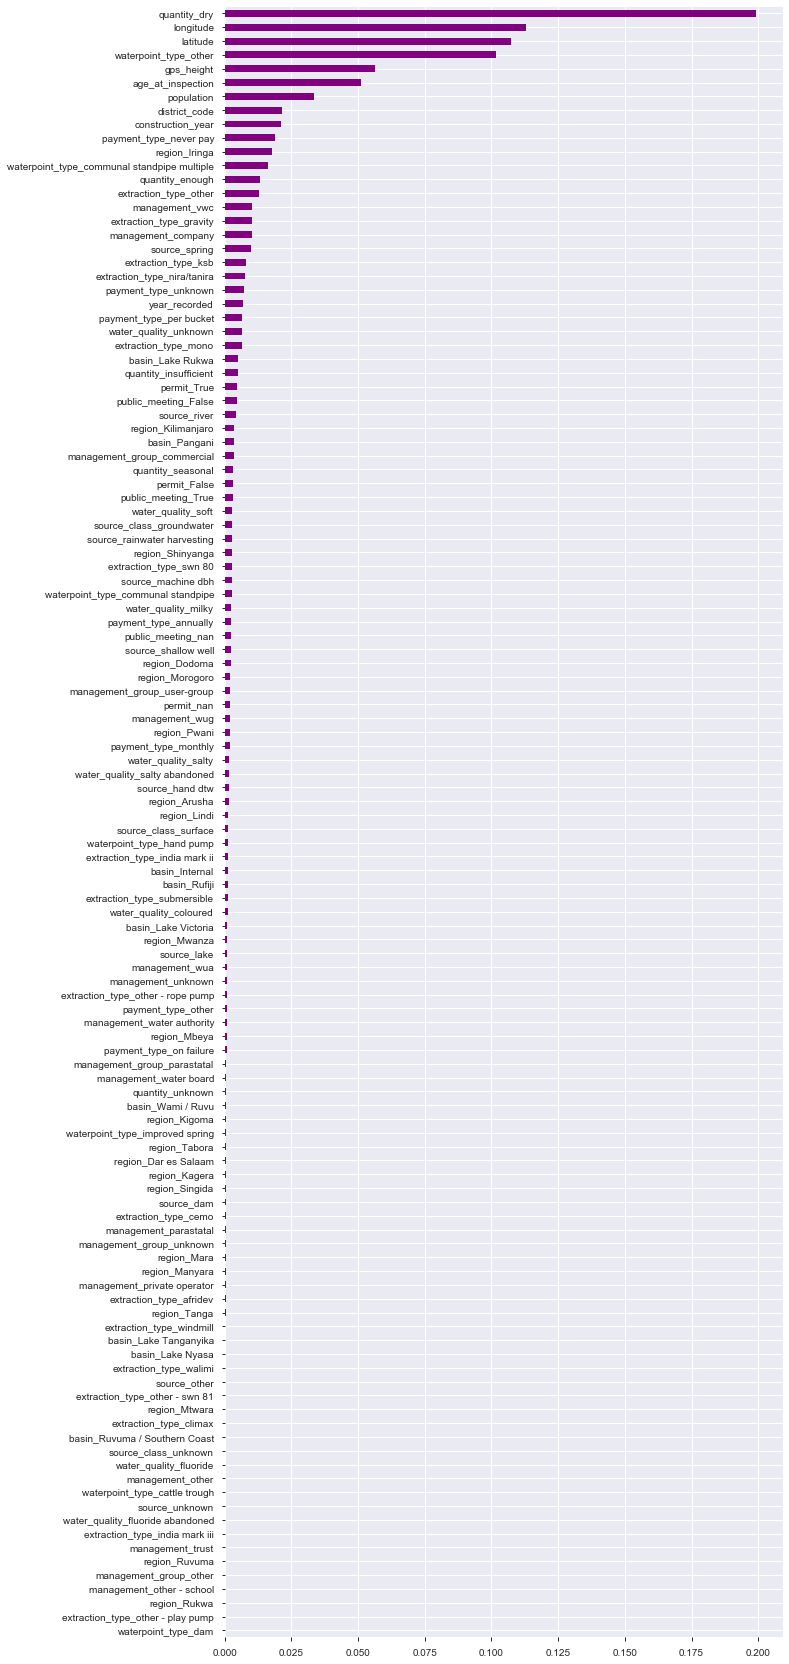

In [180]:
# Extract feature importances

model = tree_pipeline.named_steps["decisiontreeclassifier"]

encoder = tree_pipeline.named_steps["onehotencoder"]
encoded_columns = encoder.transform(X_val).columns

importances = pd.Series(model.feature_importances_, encoded_columns)

plt.figure(figsize=(10, 30))
importances.sort_values().plot.barh(color="purple");

---

#### Submit your predictions to our Kaggle competition.

(Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)

In [182]:
# Make the predictions based on testing data
y_pred = tree_pipeline.predict(X_test)
y_pred_series = pd.Series(y_pred)

In [183]:
y_pred_series.value_counts()

functional                 8816
non functional             4983
functional needs repair     559
dtype: int64

In [184]:
# Makes dataframe with id and status_group
submission = sample_submission.copy()
submission["status_group"] = y_pred_series

In [185]:
# Write submission to csv without the index
submission.to_csv("tobias-reaper-waterpump-submission-2.csv", index=False)

---

#### Commit your notebook to your fork of the GitHub repo.